### Steps:

0.1 download sparse mouse single-cell data from https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6967/

0.2 Read and Operate the large sparse matrix on the cluster

1. down sample to $10,000$ reads per cell (keep $\ge 90\%$ or $100,000$ reads/cell)


2. Gene Filter. throw out genes ($\mu < 0.05 x(M)$ and $\sigma < 0.05$)


3. $\log_2(1+X)$


4. z-score normalize

### Notes:

In the previous job, i finished the first step: downsample every cell to 10,000 reads. This process takes about 24 
hours. So i submit it as a job onto cluster and saved the complete matrix.

I will continue to the following steps in this file.

### 2. Gene Filter. throw out genes ($\mu < 0.05$ and $\sigma < 0.05$)

**2.0 read the previous matrix, check if it has been downsampled**

In [2]:
from scipy.io import mmread
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

In [10]:
mtx = mmread(r'2.mtx') # read the result matrix of step 1

mtx = mtx.tocsr()

genect = np.sum(mtx,axis=0)
genect = np.array(genect)[0]

print('Gene count per cell array, shape:', genect.shape)
print('max count:',genect.max())
print('min count:',genect.min())

Gene count per cell array, shape: (113803,)
max count: 10000
min count: 10000


According to the above output, the matrix has already been successfully downsampled

**2.1 Calculate and plot the $\mu$ and $\sigma$ for each gene**

The following functions calculate the mean and standard deviation for every **row** of a sparse matrix.

Calculate the standard deviation of a sparse matrix is little tricky, i used the equation:

$$\sigma = \sqrt{\text{Var}} = \sqrt{E(X^2) - E(X)^2}  $$

In [6]:
# This Function return the gene i number distribution
# from Sparse matrix mtx2
# The return value is a 1-D array, which is good for next statistic process 

def genedisi(mtx2,i):
    genei = mtx2[i,:]
    genei = genei.todense()
    genei = np.array(genei)
    genei = np.reshape(genei,[-1])
    return(genei)

# this function calculate 
# the mean and standard deviation 
# for every row of the sparse matrix
# The parameter nn means the process divide into small groups of nn number 
# to finish, which decrease the memory required. Or the kernel will crash down
# mtx2 should better be CSR Format 
def musigma_sp(mtx2,axis=1,nn=20):
    
    # create array for E(X)2 and E(X2)
    mu = np.zeros( mtx2.shape[1-axis] )
    sqrmu = np.zeros( mtx2.shape[1-axis] )
    
    # step number
    stepnum = np.int( np.ceil( mtx2.shape[1-axis]/nn ) )
    
    # use small step, multi times to reduce the memory consumption
    for i in tqdm(range(stepnum)):
        
        # E(X)2
        tempmu = np.mean(mtx2[(i*nn):min([(i+1)*nn,mtx2.shape[1-axis]]),:],axis=axis)
        tempmu = np.array(tempmu).reshape(-1)
        mu[(i*nn) : min([(i+1)*nn,mtx2.shape[1-axis]])]= tempmu  # E(X)
        
        # E(X2)
        sqrmtx2 = mtx2[(i*nn):min([(i+1)*nn,mtx2.shape[1-axis]]),:].copy()
        sqrmtx2.data **= 2
        temp = np.mean(sqrmtx2,axis=axis)
        sqrmu[(i*nn) : min([(i+1)*nn,mtx2.shape[1-axis]])] = np.array(temp).reshape(-1)  # E(X2)
    
    var = sqrmu - mu**2  # var = E(X2) - E(X)2
    sigma = np.sqrt(var)   # standard deviation
    
    return(mu,sigma)

In [12]:
mu,sigma = musigma_sp(mtx)

100%|██████████| 1473/1473 [00:12<00:00, 119.30it/s]


Then i plot the distribution of $\mu$ and $\sigma$ of every row of the matrix (every gene).

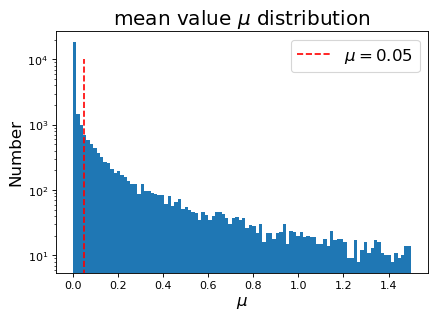

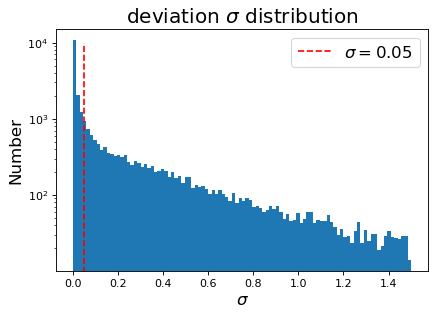

In [13]:
# plot the distribution of mu and sigma

plt.figure(dpi=80)
plt.title(r'mean value $\mu$ distribution',fontsize=18)
plt.xlabel(r'$\mu$',fontsize=15)
plt.ylabel('Number',fontsize=15)
plt.yscale('log')
plt.hist(mu,range=[0,1.5],bins=100)
plt.plot([0.05,0.05],[0,10000],'r--',label ='$\mu = 0.05$')
plt.legend(fontsize=15)
plt.show()

plt.figure(dpi=80)
plt.title(r'deviation $\sigma$ distribution',fontsize=18)
plt.xlabel(r'$\sigma$',fontsize=15)
plt.ylabel('Number',fontsize=15)
plt.yscale('log')
plt.hist(sigma,range=[0,1.5],bins=100)
plt.plot([0.05,0.05],[0,10000],'r--',label ='$\sigma = 0.05$')
plt.legend(fontsize=15)
plt.show()

**2.2 Filter out those with $\mu < 0.05$ and $\sigma < 0.05$**

In [14]:
# drop those with mu < 0.05 and sigma < 0.05
w = np.where((mu > 0.05) | (sigma > 0.05))

print(np.size(w))

w = tuple(np.array(w).reshape(-1))

mtx = mtx[w,:]

15061


In [15]:
sp.io.mmwrite(r'3.mtx',mtx,field='integer') # save the matrix

### 3. $\log_2{(1+X)}$

In [3]:
mtx = mmread(r'3.mtx').tocsr()

In [4]:
from math import log,e
a = log(e,2)
mtx = mtx.multiply(a)  # log2(1+X) = log_e(1+X)*log2(e)

### 4. z-score Normalization

Normalize the matrix along the row. Make the mean and standard deviation for every gene is 0 and 1.

In the following codes, i made a proper z-score normalization on all **non-zero** values of the sparse matrix, as a new sparse matrix;  `mtx`

Also, i store the z-score normalized “zeros” ($0-\mu/\sigma$ for each gene) in another $1\times N_{genes}$ array. `zsnorm0`

**4.1 z-score normailize the nonzeros elements for every gene**

In [7]:
# first calculate the mu and sigma for every gene
mu,sigma = musigma_sp(mtx)

100%|██████████| 754/754 [00:12<00:00, 60.35it/s]


The following function return the sparse matrix, after z-score normalizing all nonzero elements

In [10]:
# for all nonzero elements, zsn = (z - mu)/sigma
# this function is super tricky, about how to subtract a value from the nonzero elements
# in sparse matrix
# reference to https://stackoverflow.com/questions/19017804/scipy-sparse-matrix-special-substraction?rq=1

def zsn_nn(mtx,mu,sigma):
    mtx1 = mtx.copy()
    # nonzero elements number per row
    nnz_per_row = np.diff(mtx.indptr) 
    
    # duplicate the mu and sigam scalar
    muall = np.repeat(mu, nnz_per_row)
    sigmaall = np.repeat(sigma, nnz_per_row)
    
    # zsn = (z-mu)/sigma
    mtx1.data = (mtx1.data-muall) / sigmaall
    
    return(mtx1)

In [11]:
time0 = time()

mtx = zsn_nn(mtx,mu,sigma)

print('time consumption for the z-score normalization is:',time()-time0)

time consumption for the z-score normalization is: 11.767118453979492


**2.2 store the array of value of 0 after z-score normalization `zsn0`**

In [12]:
zsn0 = -mu/sigma

**2.3 test the z-score normalization result**

Select the gene i for test:

In [33]:
i = 10000
test = mtx[i,:]

N = test.shape[1] # total elements number
N1 = test.data.shape[0] # total nonzero elements number
N2 = N - N1 # zero elements number

# construnct new array for this 
newarray = np.concatenate( ( test.data , np.repeat([zsn0[i]],[N2]) ) )

# print the mean and stddev of the new array
print('mean is:', newarray.mean())
print('stddev is:', newarray.std())

mean is: 1.9979585375010507e-18
stddev is: 0.9999999999999999


As shown above, after the z-score normailization, for every gene, $\mu = 0$ and $\sigma = 1$

In [34]:
sp.io.mmwrite(r'final.mtx',mtx)

In [37]:
np.savetxt(r'zsn0.txt',zsn0,fmt='%.18f')